Direct Forecasting GRU with 64 units, 5 stride and bulding sequence that mantains also the short time series

### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/workspace

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1EdKU7CVsU6TtpK3sCxmYusBQoEgDT8M6/workspace


### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 6465

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

### Load data

In [ ]:
folder = './training_dataset/'
dataset_path = os.path.join(folder, 'training_data.npy')
dataset = np.load(dataset_path, allow_pickle=True)

categories_path = os.path.join(folder, 'categories.npy')
categories = np.load(categories_path, allow_pickle=True)

periods_path = os.path.join(folder, 'valid_periods.npy')
valid_periods = np.load(periods_path, allow_pickle=True)

print(f'dataset_shape: {dataset.shape}')
print(f'categories_shape : {categories.shape}')
print(f'valid_periods_shape : {valid_periods.shape}')


dataset_shape: (48000, 2776)
categories_shape : (48000,)
valid_periods_shape : (48000, 2)


all time series end at the same time so the zeroes are only at the beginning

###Clean data

In [ ]:
#check how many time series for categories and the lenght
count=0
for i in range(len(valid_periods)):
    #print(valid_periods[i][1] - valid_periods[i][0])
    if valid_periods[i][1] - valid_periods[i][0] < 200 :
      #print(categories[i])
      count=count+1

print(count)

24943


###process data

In [ ]:
# Convert the NumPy array to a Pandas DataFrame
df = pd.DataFrame(dataset)

# Transpose the DataFrame to get the desired shape (2776, 48000)
df_transposed = df.transpose()

# Print the shape of the transposed DataFrame
print("Shape of the transposed DataFrame:", df_transposed.shape)


Shape of the transposed DataFrame: (2776, 48000)


In [ ]:
df_transposed.head(2000)

,0,1,2,3,4,5,6,7,8,9,...,47990,47991,47992,47993,47994,47995,47996,47997,47998,47999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.510176,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.377205,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.382632,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.413840,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_transposed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2776 entries, 0 to 2775
Columns: 48000 entries, 0 to 47999
dtypes: float64(48000)
memory usage: 1016.6 MB


In [ ]:
df_transposed=df_transposed.astype(np.float32)
df_transposed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2776 entries, 0 to 2775
Columns: 48000 entries, 0 to 47999
dtypes: float32(48000)
memory usage: 508.3 MB


### visualize data

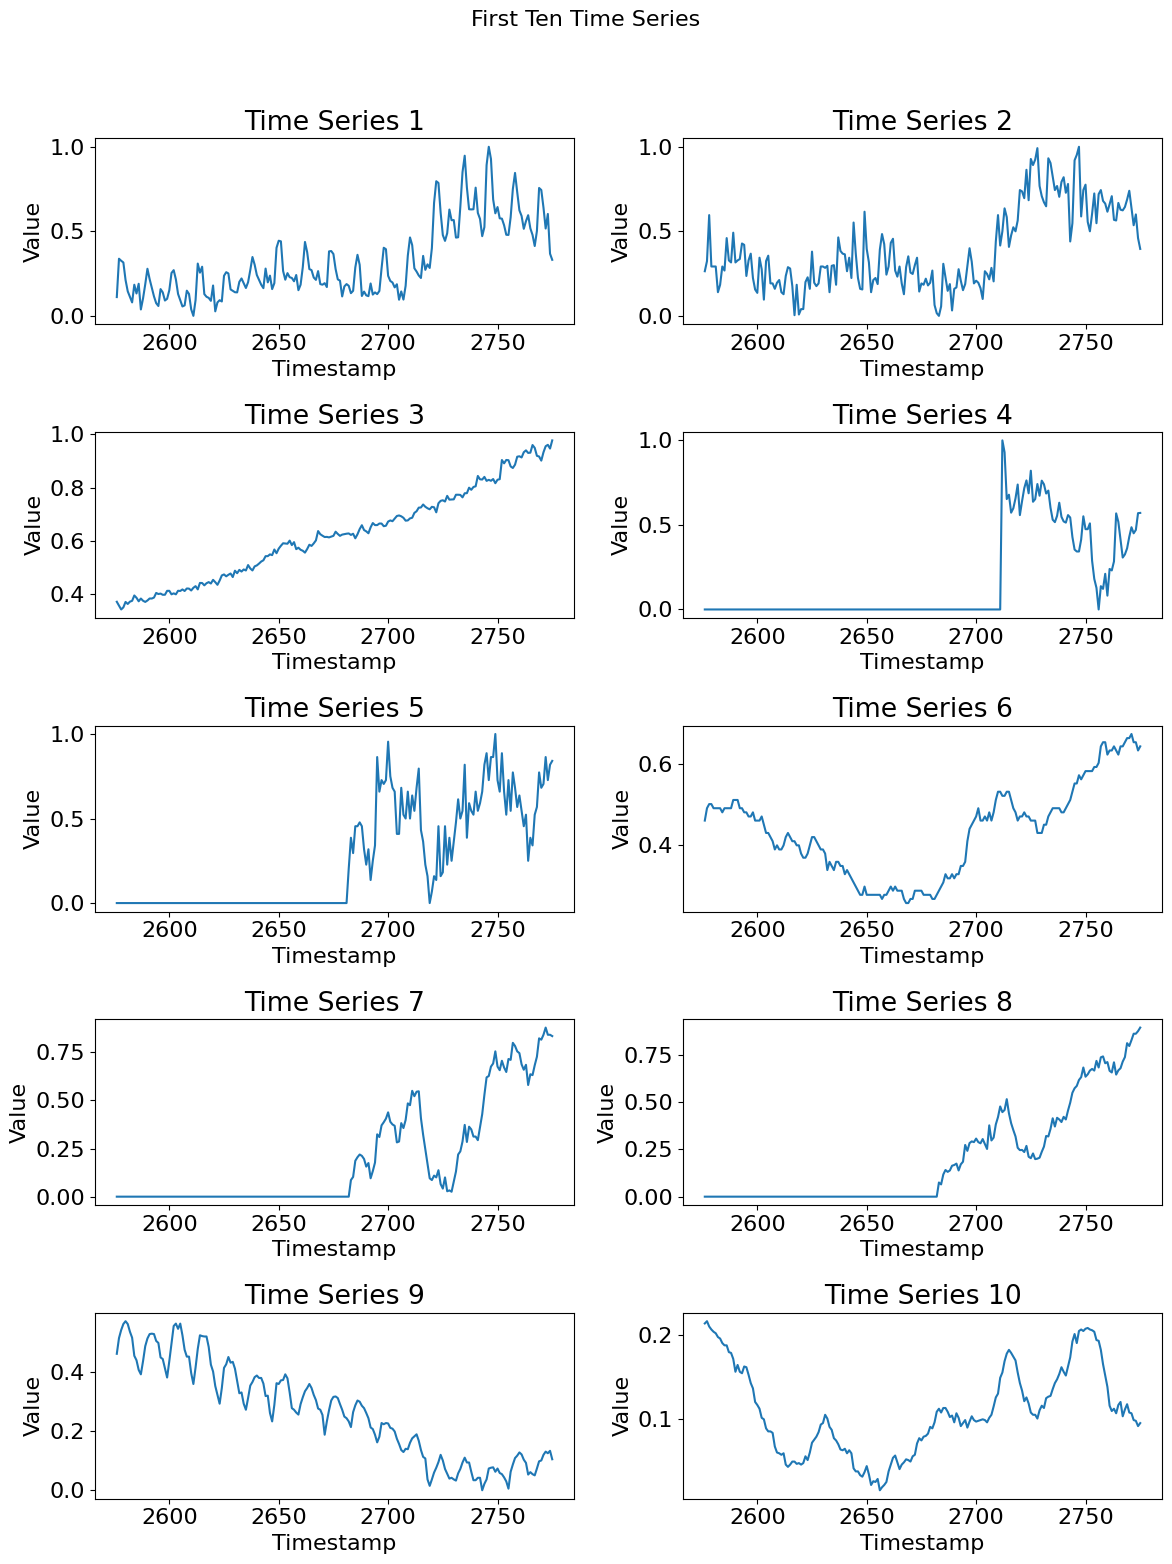

In [ ]:
def inspect_dataframe(df):
  first_ten_columns = df.iloc[-200:, :10]

  # Create ten separate subplots
  fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 16))
  fig.suptitle('First Ten Time Series', fontsize=16)

  # Flatten the axes array for easier iteration
  axes = axes.flatten()

  # Plot each time series in a separate subplot
  for i, (column, ax) in enumerate(zip(first_ten_columns.columns, axes)):
      ax.plot(first_ten_columns.index, first_ten_columns[column])
      ax.set_title(f'Time Series {i+1}')
      ax.set_xlabel('Timestamp')
      ax.set_ylabel('Value')

  # Adjust layout for better spacing
  plt.tight_layout(rect=[0, 0, 1, 0.96])

  # Show the plots
  plt.show()

inspect_dataframe(df_transposed)

Category A, Time Series Name: 25436
Category A, Time Series Name: 25109
Category A, Time Series Name: 24884
Category B, Time Series Name: 36905
Category B, Time Series Name: 46121
Category B, Time Series Name: 40306
Category C, Time Series Name: 26723
Category C, Time Series Name: 32463
Category C, Time Series Name: 28262
Category D, Time Series Name: 1074
Category D, Time Series Name: 8164
Category D, Time Series Name: 4800
Category E, Time Series Name: 16352
Category E, Time Series Name: 11628
Category E, Time Series Name: 13510
Category F, Time Series Name: 47937
Category F, Time Series Name: 47914
Category F, Time Series Name: 47988


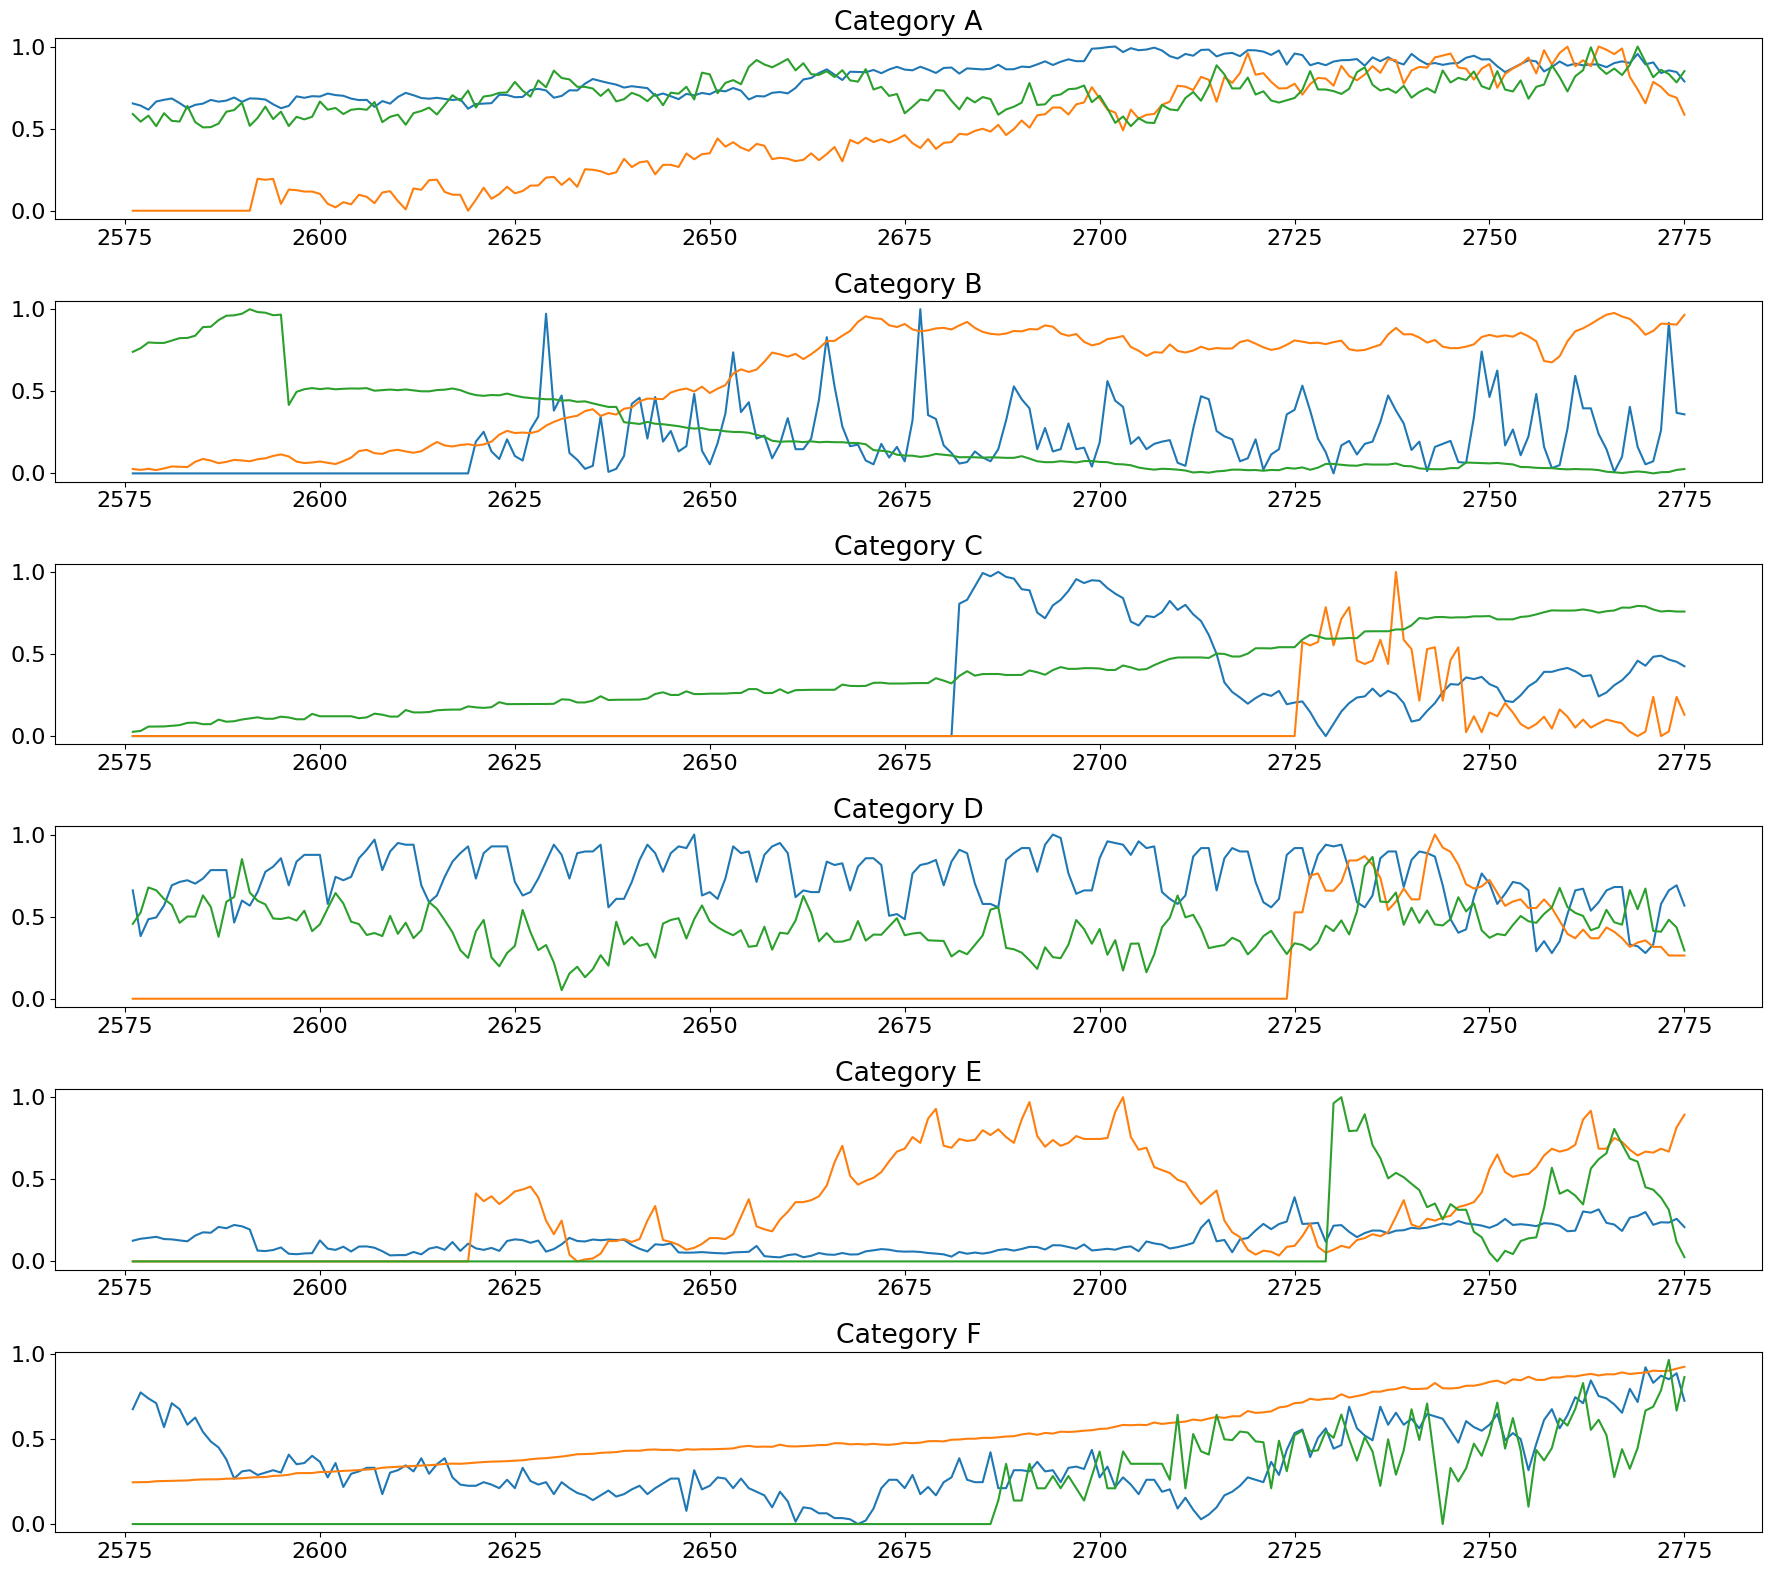

In [ ]:
def inspect_dataframe(df,numOfTimeSeries):



  # Get unique categories
  unique_categories = np.unique(categories)

  # Create a dictionary to store sampled time series for each category
  sampled_series = {category: [] for category in unique_categories}

  # Create a set to track plotted time series indices
  plotted_indices = set()

  # Set the figure size for each subplot
  fig, axs = plt.subplots(len(unique_categories), 1, figsize=(18, 16))

  # Function to randomly select and plot ten time series for a given category
  def plot_random_time_series(category, ax):
      # Get indices of time series with the given category
      category_indices = np.where(categories == category)[0]

      # Filter out indices that have already been plotted
      remaining_indices = list(set(category_indices) - plotted_indices)

      if not remaining_indices:
          return None  # No more available time series for this category

      # Randomly select ten time series from the remaining indices
      selected_indices = np.random.choice(remaining_indices, size=numOfTimeSeries, replace=False)

      for selected_index in selected_indices:
          # Get the time series data
          selected_series = df.iloc[:, selected_index]

          # Plot the last 200 timestamps
          ax.plot(selected_series.index[-200:], selected_series.values[-200:], label=f"Category {category}")

          # Store the sampled time series
          sampled_series[category].append(selected_series)

          # Mark the selected index as plotted
          plotted_indices.add(selected_index)

          # Print the category and time series name
          print(f"Category {category}, Time Series Name: {selected_series.name}")

      # Add title with category label
      ax.set_title(f"Category {category}")

      return sampled_series[category]

  # Loop until we have exactly ten plots for each category
  for i, category in enumerate(unique_categories):
      # Plot ten time series for the selected category
      plot_random_time_series(category, axs[i])

  # Adjust layout for better visualization
  plt.tight_layout()

  # Show the plots
  #plt.legend()
  plt.show()

inspect_dataframe(df_transposed,3)


###Sequential Train-Test split

In [ ]:
# we decide to use 0 for testing
test_size = 0
X_train_raw = df_transposed
#X_test_raw = df_transposed.iloc[-test_size:]
print(X_train_raw.shape)
X_train_raw.head()
print(X_train_raw)



(2776, 48000)
         0      1         2         3         4         5         6      \
0     0.000000  0.000  0.000000  0.000000  0.000000  0.000000  0.000000   
1     0.000000  0.000  0.000000  0.000000  0.000000  0.000000  0.000000   
2     0.000000  0.000  0.000000  0.000000  0.000000  0.000000  0.000000   
3     0.000000  0.000  0.000000  0.000000  0.000000  0.000000  0.000000   
4     0.000000  0.000  0.000000  0.000000  0.000000  0.000000  0.000000   
...        ...    ...       ...       ...       ...       ...       ...   
2771  0.640741  0.640  0.932531  0.486370  0.704545  0.673469  0.841492   
2772  0.516667  0.536  0.955206  0.450502  0.863636  0.653061  0.878788   
2773  0.602778  0.600  0.960481  0.470588  0.727273  0.653061  0.841492   
2774  0.367593  0.460  0.946506  0.569584  0.818182  0.632653  0.841492   
2775  0.331481  0.396  0.977140  0.571019  0.840909  0.642857  0.834499   

        7         8         9      ...     47990     47991     47992  \
0     0.00000

###normalization

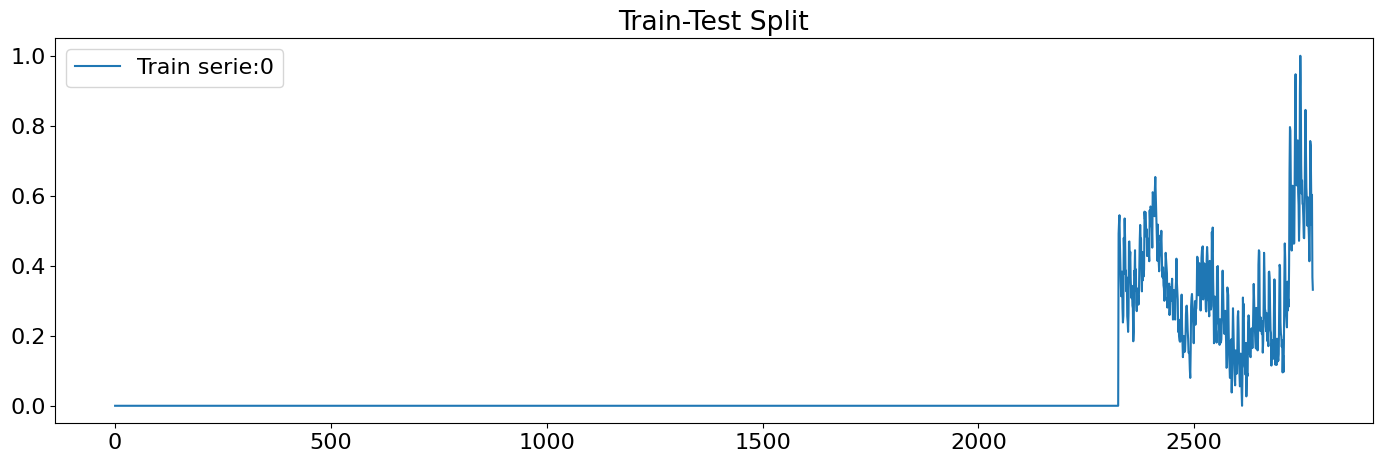

In [ ]:
# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
#X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

#print(X_train_raw)


plt.figure(figsize=(17,5))
plt.plot(X_train_raw[0], label='Train serie:0')
#plt.plot(X_test_raw[0], label='Test serie:0')
plt.title('Train-Test Split' )
plt.legend()
plt.show()

## build sequences

In [ ]:
# Function to extract valid interval for a given time series index
def get_valid_interval(df, ar_valid, ts_index):
    start, end = ar_valid[ts_index, 0], ar_valid[ts_index, 1]
    valid_interval = df.iloc[start:end+1,ts_index ]
    return valid_interval

#print( get_valid_interval(df_transposed,valid_periods,0) )

In [ ]:

def build_sequences(df, window=200, stride=5, telescope=18):

    # Sanity check to avoid runtime errors
    assert window % stride == 0

    data_sequence = []
    labels_sequence = []
    categories_extend = []

    for series_index in range(df.shape[1]) :

        #get only the valid part of each serie
        serie=get_valid_interval(df_transposed,valid_periods,series_index)
        valid_serie = serie.copy().values
        #TESTING
        #print(valid_serie)
        #print(len(valid_serie))

        if(len(valid_serie)%stride!=telescope):
          #check size of time series
          padding_check = len(valid_serie)%stride
          if(padding_check != 0): #true = serve il padding
              padding_len = stride - len(valid_serie)%stride # Compute padding length

              padding = np.zeros((padding_len), dtype='float32')
              valid_serie = np.concatenate((padding,valid_serie))

            #print(valid_serie)

          #concatenate telescope
          valid_serie=np.concatenate((np.zeros((telescope), dtype='float32'), valid_serie))



        #print(len(valid_serie))
        if(len(valid_serie)>window+telescope):
              for idx in np.arange(0,len(valid_serie)-window-telescope,stride):
                  data_sequence.append(valid_serie[idx:idx+window])
                  labels_sequence.append(valid_serie[idx+window:idx+window+telescope])
                  #print(len(data_sequence))
                  categories_extend.append(categories[series_index])


        else:

            if(len(valid_serie)<window+telescope):
              i=0
              padding = np.zeros(window+telescope-len(valid_serie), dtype='float32')
              valid_serie = np.concatenate((padding,valid_serie))
              data_sequence.append(valid_serie[i:i+window])
              labels_sequence.append(valid_serie[i+window:i+window+telescope])
              categories_extend.append(categories[series_index])



    data_s = np.array(data_sequence)
    labels = np.array(labels_sequence)
    return data_s, labels,categories_extend



"\n        else:\n          #è il caso in cui valid_serie=window_size, cioè la valid_serie è di 200 (cioè era meno di 200 e abbiamo fatto il padding)\n              i=0\n              padding = np.zeros(telescope, dtype='float32')\n              valid_serie = np.concatenate((padding,valid_serie))\n              data_sequence.append(valid_serie[i:i+window])\n              labels_sequence.append(valid_serie[i+window:i+window+telescope])\n              categories_extend.append(categories[series_index])\n"

In [ ]:
window = 200
stride = 5
telescope = 18

## Monovariate Forecasting (Direct)

In [ ]:
direct_telescope = telescope #direct forecasting

In [ ]:

from sklearn.model_selection import train_test_split

X_train, y_train, categories_ext = build_sequences(X_train_raw, window, stride, direct_telescope)
#X_test, y_test = build_sequences(X_test_raw, window, stride, direct_telescope)


X_train,X_val, y_train, y_val= train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    stratify=categories_ext,
    random_state=seed
)


X_train.shape, y_train.shape, X_val.shape, y_val.shape

Number of rows removed: 192703


((485229, 200), (485229, 9), (53915, 200), (53915, 9))

In [ ]:

def inspect_multivariate(X, y,telescope, numOfSeq=2, idx=None):
  if(idx==None):
      idx=np.random.randint(0,len(X))


  figs, axs = plt.subplots(numOfSeq, 1, sharex=True, figsize=(17,17))
  for i in range(numOfSeq):
      axs[i].plot(np.arange(len(X[0,:])), X[idx,:])
      axs[i].scatter(np.arange(len(X[0,:]), len(X_train[0,:])+telescope), y[idx,:], color='orange')
      axs[i].set_title('series number:'+str(idx))
      axs[i].set_ylim(0,1)
      idx=np.random.randint(0,len(X))

  plt.show()


In [ ]:
inspect_multivariate(X_train, y_train, direct_telescope)
#inspect_dataframe(pd.DataFrame(X_train).transpose())
#inspect_dataframe(pd.DataFrame(y_train).transpose())

i punti arancioni sono quello che vogliamo predire

In [ ]:
#expand dimension
X_train=np.expand_dims(X_train,axis=2)
y_train=np.expand_dims(y_train,axis=2)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200
print(input_shape)
print(output_shape)

(200, 1)
(9, 1)


In [ ]:
from tensorflow.keras.layers import Masking, LSTM, Dense

In [ ]:
#we can merge convolution and GRU
def build_GRU_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')


    # Add a Bidirectional GRU layer with 64 units
    x = tfkl.Bidirectional(tfkl.GRU(64, return_sequences=True, name='gru'), name='bidirectional_gru')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]


    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_GRU_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "CONV_GRU_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_gru (Bidirec  (None, 200, 128)          25728     
 tional)                                                         
                                                                 
 conv (Conv1D)               (None, 200, 128)          49280     
                                                                 
 output_layer (Conv1D)       (None, 200, 1)            385       
                                                                 
 cropping (Cropping1D)       (None, 9, 1)              0         
                                                                 
Total params: 75393 (294.50 KB)
Trainable params: 75393 (294.50 KB)
Non-trainable params: 0 (0.00 Byte)
______________

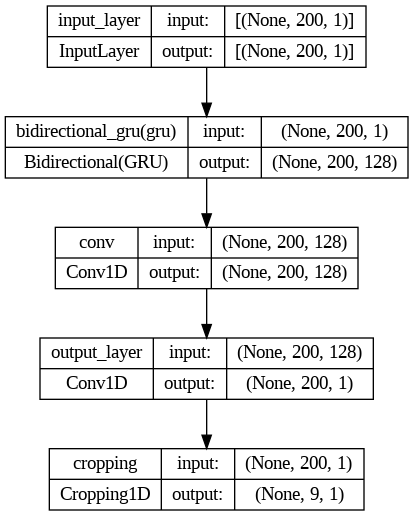

In [ ]:
model = build_GRU_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
print(X_train)
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data =(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-8),
         tfk.callbacks.ModelCheckpoint("DirectForecastingGRU", verbose=1,monitor='val_loss', save_best_only=True, mode='min')
    ]
).history

In [ ]:
model.save('DirectForecastingGRU')